In [1]:
import train
import numpy as np
import api.capital_features_api as cf
import pandas as pd
import mplfinance as mpf
from datetime import datetime
import joblib
import matplotlib.pyplot as plt
import model_util as mu
from tensorflow import keras
import os
import shutil

model_name = 'v8.40.240.i5.e20f.lstm1.sp22y1d.20240203'
model_dir = './model/' + model_name + '/'
os.makedirs(model_dir, exist_ok=True)
scaler_save_file = model_dir + 'scaler.save'
scaler_json_file = model_dir + 'scaler.json'
model_h5_file = model_dir + 'model.h5'
model_tf_dir_file = model_dir + 'model_tf'
model_tf_dir_scaler_json_file = model_tf_dir_file + '/scaler.json'

In [ ]:
train_ud_data = cf.get_train_data(cf.docker_train_data_url, train_config_id=1585649)
validation_ud_data = cf.get_train_data(cf.docker_train_data_url, train_config_id=1585650)
Y_ud_train = train_ud_data['upSignals']
Y_ud_val = validation_ud_data['upSignals']

In [ ]:
train_ud_dataset, validation_ud_dataset, scaler_ud = train.to_dataset(train_ud_data, validation_ud_data, Y_ud_train, Y_ud_val)
weights_ud = train.to_weights(Y_ud_train)
joblib.dump(scaler_ud, scaler_save_file)
train.save_scaler(scaler_ud, scaler_json_file)

In [ ]:
model_ud, callbacks_ud = train.get_model(5, 40, model_name)

In [ ]:
his_ud = model_ud.fit(train_ud_dataset, epochs=500, validation_data=validation_ud_dataset, verbose=1, callbacks=callbacks_ud, class_weight=weights_ud)
model_ud.save(model_h5_file)
model_ud.save(model_tf_dir_file, save_format='tf')
shutil.copy2(scaler_json_file, model_tf_dir_scaler_json_file)

In [ ]:
plt.plot(his_ud.history['accuracy'], label='accuracy')
plt.plot(his_ud.history['val_accuracy'], label='val_accuracy')
plt.plot(his_ud.history['loss'], label='loss')
plt.plot(his_ud.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [2]:
model_ud = keras.models.load_model(model_tf_dir_file)
scaler_ud = joblib.load(scaler_save_file)

In [28]:
prediction_data = cf.get_prediction_data(cf.docker_prediction_data_url, train_config_id=1585649, start="2022-07-11", end="2023-11-14")
kline = cf.get_kline_histroy(cf.docker_kline_history_url, start="2022-07-11", end="2023-11-14", code='QQQ')
df = cf.his_to_df(kline)

In [29]:
X_prediction_scaled = train.to_prediction_scaled(prediction_data, scaler_ud)
Y_ud_prediction = model_ud.predict(X_prediction_scaled)

11/11 [==============================] - 0s 7ms/step


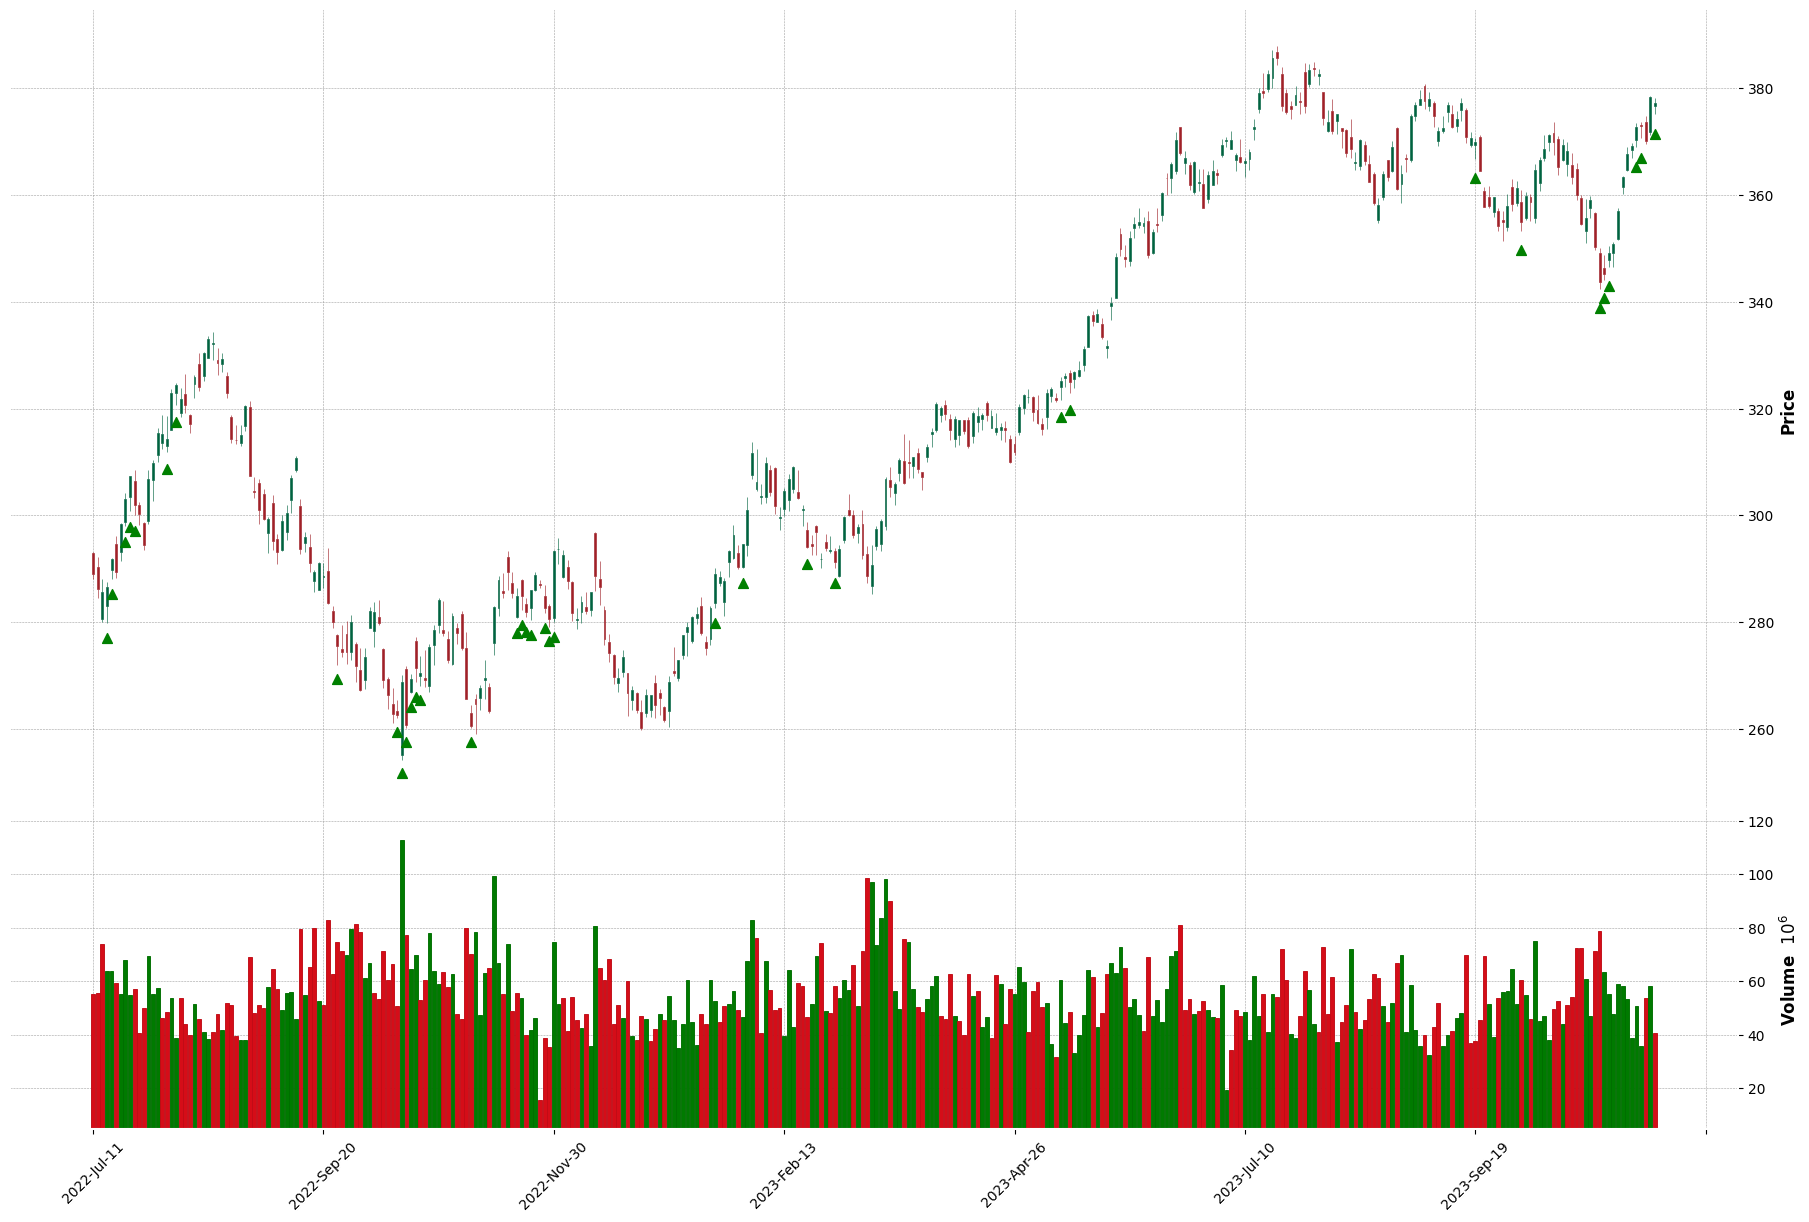

In [30]:
predictions_ud_series = pd.Series(Y_ud_prediction.flatten(), index=df.index)
buy_signals = np.full(df.shape[0], np.nan)  # 含 NaN 的数组，与 df 的长度一致
buy_signals[predictions_ud_series > 0.9] = df['low'][predictions_ud_series > 0.9] * 0.99
buy_markers = mpf.make_addplot(buy_signals, type='scatter', markersize=50, marker='^', color='g')

mpf.plot(df, type='candle', style='charles', addplot=[buy_markers], volume=True, figsize=(24, 16))

In [ ]:
model_ud, callbacks_ud = train.get_model(5, 40, model_name, 1.5625e-05)
model_ud.load_weights('./epoch/'+model_name+'/epoch_531.ckpt')
model_ud.save(model_h5_file)
model_ud.save(model_tf_dir_file, save_format='tf')
shutil.copy2(scaler_json_file, model_tf_dir_scaler_json_file)